# TIF360 Project

# Data Pre-processing

Main source: https://www.kaggle.com/code/rmonge/predicting-molecule-properties-based-on-its-smiles/notebook

### Import packages

In [1]:
import os
import rdkit
from rdkit import Chem  # To extract information of the molecules
from rdkit.Chem import Draw  # To draw the molecules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch_geometric
from torch_geometric.loader import DataLoader
import torch_geometric.utils as utils
import networkx as nx
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool, GraphConv, GATConv, GCNConv
import torch.nn.functional as F

from sklearn.metrics import r2_score

/opt/homebrew/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define function to read xyz files

In [2]:
def read_xyz(path):
    """
    Reads the xyz files in the directory on 'path'
    Input
    path: the path to the folder to be read
    
    Output
    atoms: list with the characters representing the atoms of a molecule
    coordinates: list with the cartesian coordinates of each atom
    smile: list with the SMILE representation of a molecule
    prop: list with the scalar properties
    """
    atoms = []
    coordinates = []

    with open(path, 'r') as file:
        lines = file.readlines()
        n_atoms = int(lines[0])  # the number of atoms
        smile = lines[n_atoms + 3].split()[0]  # smiles string
        prop = lines[1].split()[2:]  # scalar properties

        # to retrieve each atmos and its cartesian coordenates
        for atom in lines[2:n_atoms + 2]:
            line = atom.split()
            # which atom
            atoms.append(line[0])

            # its coordinate
            # Some properties have '*^' indicading exponentiation 
            try:
                coordinates.append(
                    (float(line[1]),
                     float(line[2]),
                     float(line[3]))
                    )
            except:
                coordinates.append(
                    (float(line[1].replace('*^', 'e')),
                     float(line[2].replace('*^', 'e')),
                     float(line[3].replace('*^', 'e')))
                    )
                    
    return atoms, coordinates, smile, prop

### Read xyz files

In [3]:
directory = '../data/dsgdb9nsd.xyz/'

# Reads the xyz files and return the properties, smiles and coordinates
data = []
smiles = []
properties = []
for file in os.listdir(directory):
    path = os.path.join(directory, file)
    atoms, coordinates, smile, prop = read_xyz(path)
    data.append((atoms, coordinates)) # A tuple with the atoms and its coordinates 
    smiles.append(smile) # The SMILES representation
    properties.append(prop) # The molecules properties

properties_names = ['A', 'B', 'C', 'mu', 'alfa', 'homo', 'lumo', 'gap', 'R²', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']
df = pd.DataFrame(properties, columns = properties_names).astype('float32')
df['smiles'] = smiles
df.head()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles
0,3.69951,1.23093,1.09709,5.0509,78.300003,-0.2676,0.0141,0.2818,1120.841675,0.137571,-380.797821,-380.790497,-380.789551,-380.829712,28.666000,N#CC1NC11C2CC1C2
1,3.58161,1.13798,0.87264,2.5256,55.400002,-0.2868,-0.0597,0.2271,1180.509888,0.064339,-525.783386,-525.775940,-525.774963,-525.816223,25.955000,OC1=NON=C1OC=O
2,2.35658,1.75261,1.52228,1.5279,83.849998,-0.2229,0.0807,0.3036,1029.117920,0.196525,-367.186554,-367.178741,-367.177795,-367.218262,32.345001,CC12CCC1CN1CC21
3,2.20077,1.50794,0.92898,2.1100,72.110001,-0.2575,-0.0123,0.2451,1230.847534,0.136089,-455.191772,-455.182800,-455.181854,-455.226044,32.000000,CN=C1OC(=O)CC1N
4,2.43658,1.01176,0.74884,2.7860,75.680000,-0.2791,0.0257,0.3048,1496.103638,0.168867,-440.291351,-440.280579,-440.279633,-440.327576,37.969002,CC(CO)C(CO)C#N


### Investigate how cordianets are specified

In [6]:
# Print cordinates of first molecule in data
print(data[0][1])

[(-0.1158211823, -1.1588814083, 0.0253875797), (-0.0634755918, -0.0038135736, 0.037200671), (0.0110718662, 1.4360892201, 0.0060552095), (0.5872156127, 2.0980870138, 1.2241547256), (1.3066483466, 2.1572458324, -0.0191184789), (2.7569832432, 1.7502741759, -0.3116380498), (2.4855003157, 2.2287618766, -1.7724735543), (1.8365633238, 3.3230156624, -0.8677898469), (3.1222090314, 3.2335825367, 0.0190305135), (-0.8402848187, 1.9119567184, -0.4739629271), (0.0720428663, 2.9567193044, 1.4093287021), (3.2686458366, 0.8463850226, 0.0131731084), (3.3646646552, 2.5453426122, -2.3375094804), (1.8106735614, 1.6191840124, -2.3774773862), (1.2994311493, 4.2188724372, -1.1813921281), (3.0295061775, 3.5421096693, 1.06234023), (4.0399128268, 3.6114038773, -0.4376163482)]


### Draw a few of the molecules

Number of NaNs:  0


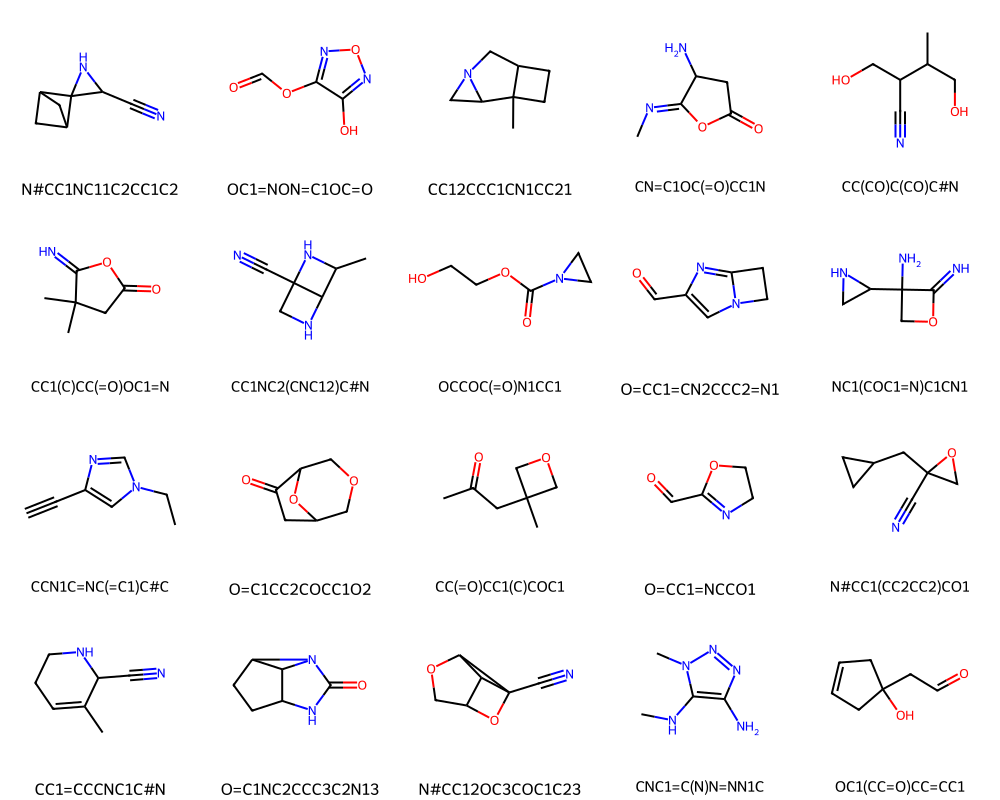

In [7]:
# Reading each molecule by its SMILES string
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

# Checking if there are None values
print("Number of NaNs: ", df['mol'].isnull().sum())

# Reads and prints the 20 first molecules
mol = df['mol'][:20]

Draw.MolsToGridImage(mol, molsPerRow=5, useSVG=True, legends=list(df['smiles'][:20].values))

### Add Hydrogens

In [8]:
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))

### Count the number of atoms and heavy atoms

In [9]:
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

df.head()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_of_atoms,num_of_heavy_atoms
0,3.69951,1.23093,1.09709,5.0509,78.300003,-0.2676,0.0141,0.2818,1120.841675,0.137571,-380.797821,-380.790497,-380.789551,-380.829712,28.666000,N#CC1NC11C2CC1C2,<rdkit.Chem.rdchem.Mol object at 0x2c0c50580>,17,9
1,3.58161,1.13798,0.87264,2.5256,55.400002,-0.2868,-0.0597,0.2271,1180.509888,0.064339,-525.783386,-525.775940,-525.774963,-525.816223,25.955000,OC1=NON=C1OC=O,<rdkit.Chem.rdchem.Mol object at 0x2c0c513f0>,11,9
2,2.35658,1.75261,1.52228,1.5279,83.849998,-0.2229,0.0807,0.3036,1029.117920,0.196525,-367.186554,-367.178741,-367.177795,-367.218262,32.345001,CC12CCC1CN1CC21,<rdkit.Chem.rdchem.Mol object at 0x2c0c51460>,22,9
3,2.20077,1.50794,0.92898,2.1100,72.110001,-0.2575,-0.0123,0.2451,1230.847534,0.136089,-455.191772,-455.182800,-455.181854,-455.226044,32.000000,CN=C1OC(=O)CC1N,<rdkit.Chem.rdchem.Mol object at 0x2c0c514d0>,17,9
4,2.43658,1.01176,0.74884,2.7860,75.680000,-0.2791,0.0257,0.3048,1496.103638,0.168867,-440.291351,-440.280579,-440.279633,-440.327576,37.969002,CC(CO)C(CO)C#N,<rdkit.Chem.rdchem.Mol object at 0x2c0c51540>,20,9


### Make canonical SMILE

In [10]:
def canonize(mol):
    return Chem.MolToSmiles(Chem.MolFromSmiles(mol), isomericSmiles=True, canonical=True)

canon_smile = []
for molecule in smiles:
    canon_smile.append(canonize(molecule))
    
df['canon_smiles'] = canon_smile

df.head()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_of_atoms,num_of_heavy_atoms,canon_smiles
0,3.69951,1.23093,1.09709,5.0509,78.300003,-0.2676,0.0141,0.2818,1120.841675,0.137571,-380.797821,-380.790497,-380.789551,-380.829712,28.666000,N#CC1NC11C2CC1C2,<rdkit.Chem.rdchem.Mol object at 0x2c0c50580>,17,9,N#CC1NC12C1CC2C1
1,3.58161,1.13798,0.87264,2.5256,55.400002,-0.2868,-0.0597,0.2271,1180.509888,0.064339,-525.783386,-525.775940,-525.774963,-525.816223,25.955000,OC1=NON=C1OC=O,<rdkit.Chem.rdchem.Mol object at 0x2c0c513f0>,11,9,O=COc1nonc1O
2,2.35658,1.75261,1.52228,1.5279,83.849998,-0.2229,0.0807,0.3036,1029.117920,0.196525,-367.186554,-367.178741,-367.177795,-367.218262,32.345001,CC12CCC1CN1CC21,<rdkit.Chem.rdchem.Mol object at 0x2c0c51460>,22,9,CC12CCC1CN1CC12
3,2.20077,1.50794,0.92898,2.1100,72.110001,-0.2575,-0.0123,0.2451,1230.847534,0.136089,-455.191772,-455.182800,-455.181854,-455.226044,32.000000,CN=C1OC(=O)CC1N,<rdkit.Chem.rdchem.Mol object at 0x2c0c514d0>,17,9,CN=C1OC(=O)CC1N
4,2.43658,1.01176,0.74884,2.7860,75.680000,-0.2791,0.0257,0.3048,1496.103638,0.168867,-440.291351,-440.280579,-440.279633,-440.327576,37.969002,CC(CO)C(CO)C#N,<rdkit.Chem.rdchem.Mol object at 0x2c0c51540>,20,9,CC(CO)C(C#N)CO


### Next we want to remove duplicates

In [11]:
print(df['canon_smiles'][df['canon_smiles'].duplicated()])

# Can see there are 87 duplicates
print("Number of rows: ", len(df['canon_smiles']))
# Drop duplicates:
ind = df.index[df['canon_smiles'].duplicated()]
df = df.drop(ind)
print("Number of rows: ", len(df['canon_smiles']))



17903             NC=Nc1cnccn1
24934             Cc1cnc(F)cn1
27909            CN(C)c1cnccn1
28007     O=[N+]([O-])c1cnccn1
30292          c1cnc(N2CC2)cn1
                  ...         
131653           CC(C)c1cnccn1
132483           CNc1cnc(F)cn1
133438          C#Cc1cnc(O)cn1
133655          N#Cc1cnc(O)cn1
133850          C#Cc1cnc(N)cn1
Name: canon_smiles, Length: 87, dtype: object
Number of rows:  133885
Number of rows:  133798


### Remake mol based on the canonical SMILEs

In [12]:
df['mol'] = df['canon_smiles'].apply(lambda x: Chem.MolFromSmiles(x))

### Investigate data and remove outliers

In [13]:
print(df.describe()) # A has very high std, need to investigate further


                   A              B              C             mu  \
count  133798.000000  133798.000000  133798.000000  133798.000000   
mean        9.817750       1.406112       1.124983       2.706031   
std      1810.044312       1.584190       1.095906       1.530326   
min         0.000000       0.337120       0.331180       0.000000   
25%         2.554310       1.091790       0.910563       1.588800   
50%         3.089935       1.370030       1.078720       2.500050   
75%         3.834450       1.653957       1.279640       3.635900   
max    619867.687500     437.903870     282.945465      29.556400   

                alfa           homo           lumo            gap  \
count  133798.000000  133798.000000  133798.000000  133798.000000   
mean       75.192825      -0.239977       0.011164       0.251141   
std         8.187128       0.022133       0.046922       0.047506   
min         6.310000      -0.428600      -0.175000       0.024600   
25%        70.379997      -0.2525

In [14]:
print(df['A'].nlargest(100))
df = df.drop([26443,103448])
df = df.drop([483, 14561])


26443     619867.687500
103448    232663.781250
88169        799.588135
87471        293.609741
79580        285.488403
              ...      
13919         20.004910
122768        19.996969
54761         19.987490
29646         19.972509
45886         19.925831
Name: A, Length: 100, dtype: float32


In [15]:
print(df['A'].nlargest(100))

88169     799.588135
87471     293.609741
79580     285.488403
62814     160.280411
117817    160.026535
             ...    
54761      19.987490
29646      19.972509
45886      19.925831
28888      19.878059
11112      19.797871
Name: A, Length: 100, dtype: float32


In [16]:

print(df[df['A'] > 100])

# Drop outliers
df = df.drop([483, 14561])

                 A           B           C      mu        alfa    homo  \
18411   159.871170    0.379330    0.379330  1.9087  143.529999 -0.2266   
20530   159.619873    0.782570    0.782570  6.3203   82.739998 -0.2665   
21521   159.934586    0.783440    0.783440  1.5732   92.339996 -0.2323   
23642   159.655106    0.377100    0.377100  7.3662  130.860001 -0.2540   
62612   127.834969   24.858721   23.978720  1.5258   16.969999 -0.2653   
62814   160.280411    8.593230    8.593210  0.7156   28.780001 -0.2609   
71061   159.035675    9.223270    9.223240  3.8266   24.450001 -0.3264   
79580   285.488403   38.982300   34.298920  2.1089   14.180000 -0.2670   
87471   293.609741  293.541107  191.393967  1.6256    9.460000 -0.2570   
88169   799.588135  437.903870  282.945465  1.8511    6.310000 -0.2928   
95621   157.711807  157.709976  157.706985  0.0000   13.210000 -0.3877   
117817  160.026535    2.048960    2.048960  1.1881   54.540001 -0.2420   
126231  159.561462    2.076230    2.07

KeyError: '[483, 14561] not found in axis'

In [17]:
print(df.describe()) # Problem solved

                   A              B              C             mu  \
count  133794.000000  133794.000000  133794.000000  133794.000000   
mean        3.446025       1.406117       1.124985       2.706071   
std         3.190726       1.584212       1.095921       1.530306   
min         0.000000       0.337120       0.331180       0.000000   
25%         2.554310       1.091790       0.910570       1.588800   
50%         3.089925       1.370030       1.078720       2.500100   
75%         3.834415       1.653957       1.279632       3.635900   
max       799.588135     437.903870     282.945465      29.556400   

                alfa           homo           lumo            gap  \
count  133794.000000  133794.000000  133794.000000  133794.000000   
mean       75.192513      -0.239978       0.011164       0.251142   
std         8.186293       0.022132       0.046922       0.047506   
min         6.310000      -0.428600      -0.175000       0.024600   
25%        70.379997      -0.2525

### <font color='red'> Will not download dataframe since it's likely to be too big to be commited in github <font>

# Investigate Neural Networks

## Graph Neural Networks

#### Convert data to graphs

In [18]:
# import packages
from rdkit.Chem import GetAdjacencyMatrix
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader

In [19]:
def one_hot_encoding(x, permitted_list):
    if x not in permitted_list:
        x = permitted_list[-1]  # If the atom is not in the list, get "Unknown"
        
    binary_encoding = [int(boolean) for boolean in list(map(lambda s: x==s, permitted_list))]
    
    return binary_encoding    

Atom featurisation\
Currently generates ca. 80 node features

In [20]:
def get_atom_features(atom, use_chirality = True, hydrogens_implicit = True):
    # list of permitted atoms
    permitted_atom_list = ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca',
                           'Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co',
                           'Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt',
                           'Hg','Pb','Unknown']
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_atom_list)
    
    n_heavy_neighbors = one_hot_encoding(int(atom.GetDegree()), [0,1,2,3,4,"MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, 'Extreme'])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_ring_enc = one_hot_encoding(int(atom.IsInRing()), [0, 1])
    
    is_aromatic_enc = one_hot_encoding(int(atom.GetIsAromatic()), [0, 1])
    
    atomic_mass_scaled = [float(atom.GetMass() - 10.812)/116.092] # (?) replace 10.812 with mean the and 116.092 with std
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)] # (?) replace 1.5 with mean the and 0.6 with std
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)] # (?) replace 0.64 with mean the and 0.76 with std
                              
    atom_feature_vector = atom_type_enc + n_heavy_neighbors + formal_charge_enc + hybridisation_type_enc + is_in_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
    
    if use_chirality:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
        
    if hydrogens_implicit:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc
        
    return np.array(atom_feature_vector) 

Bond Featurisation\
Currently generates ca. 10 edge features

In [21]:
def get_bond_features(bond, use_stereochemistry=True):
    permitted_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, 
                            Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    
    bond_type_enc = one_hot_encoding(str(bond.GetBondType()), permitted_bond_types)
    
    bond_is_conjugated_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conjugated_enc + bond_is_in_ring_enc
    
    if use_stereochemistry:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc
        
    return np.array(bond_feature_vector)

Define function to generate dataset of labeled Pytorch Geometric Graphs

In [26]:
x_smiles = df.smiles.values
y = df.loc[:, properties_names].values  # shape = (n_samples, n_properties)
print(x_smiles.shape)
print(y.shape)



(133794,)
[ 3.5816100e+00  1.1379800e+00  8.7264001e-01  2.5256000e+00
  5.5400002e+01 -2.8680000e-01 -5.9700001e-02  2.2710000e-01
  1.1805099e+03  6.4338997e-02 -5.2578339e+02 -5.2577594e+02
 -5.2577496e+02 -5.2581622e+02  2.5955000e+01]


/var/folders/q_/7fkh9kxx2gs8xdl51_6vwkx80000gn/T/ipykernel_47852/3040824227.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  dataset = pd.concat(x_smiles,y,axis=0)


TypeError: concat() got multiple values for argument 'axis'

Split data into train and test set

In [36]:
from torch_geometric.loader import DataLoader

# split the dataset into test and validation:
num_samples = len(dataset)

# Want to divide data randomly
random_indexes = np.array(random.sample(range(num_samples), num_samples)) # random.sample ensures no duplicates

train_data = [dataset[index] for index in random_indexes[int(.2 * num_samples ) :]] # 80%
test_data = [dataset[index] for index in random_indexes[: int(.2 * num_samples )]] # 20%

print(num_samples)
print(len(train_data))
print(len(test_data))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

133791
107033
26758


### Transformer Network

#### Model for all targets at once

Transformer

In [27]:
data_labels = x_smiles.shape[0]
data_features = y.shape[1]

print(data_labels)
print(data_features)

class Transformer(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.Attention = torch.nn.MultiheadAttention(data_features,num_heads=3,dropout=0.15)
        self.Norm1 = torch.nn.LayerNorm(data_features)
        self.Dense1 = torch.nn.Linear(hidden_channels)
        self.Norm2 = torch.nn.LayerNorm(hidden_channels)
        self.Dense2 = torch.nn.Linear(hidden_channels)
        

    def forward(self, x, edge_index, edge_attr, batch): 
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv4(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv5(x, edge_index, edge_attr)

        #Returns batch-wise graph-level-outputs by averaging node features across the node dimension, so that for a single graph G
        #its output is computed by
        x = global_mean_pool(x, batch) 
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(x)
        x = self.lin3(x)
        
 
        return x
    

133794
15


Train GNN

In [43]:
model = GNN(hidden_channels=64) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

def train(data_in):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data_in.x, data_in.edge_index, data_in.edge_attr, data_in.batch)  # Perform a single forward pass.

      #Alt 1
      loss = criterion(out, data_in.y) 

      #Alt 2
      #loss = 0
      #for item in range(0,len(data_in.y[0,:])):
      #      loss += criterion(out[:,item], data_in.y[:,item]) 

      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(data):
      all_test_r2 = []
      counter = -1    
      for data_in in data:
            counter += 1
            model.eval()
            out = model(data_in.x, data_in.edge_index, data_in.edge_attr, data_in.batch)

            # Caculate R2
            r2_score_var = []
            for item in range(0,data_in.y.shape[1]):
                  if item == 0:
                        r2_score_var = r2_score(data_in.y[:,item].detach().numpy(), out[:,item].detach().numpy())
                  else:
                        r2_score_var = np.vstack((r2_score_var,(r2_score(data_in.y[:,item].detach().numpy(), out[:,item].detach().numpy()))))

            if counter == 0:
                  all_test_r2 = r2_score_var
            else:
                  all_test_r2 = np.hstack((all_test_r2,r2_score_var))

      average_test_r2 = np.sum(all_test_r2,axis=1) / all_test_r2.shape[1]

      return average_test_r2

# Vectors to append accuracy to:
Train_r2 = []
Test_r2 = []

# Calculate accuracy before training 
Train_r2.append(test(train_loader))
Test_r2.append(test(test_loader))
print("Initial training R2: ", Train_r2[0])
print("Initial test R2: ", Test_r2[0])

print_r2_option = True
for epoch in range(1, 101):
      average_loss = []
      for data in train_loader:
            loss = train(data)
            average_loss.append(loss)
      print(f'Epoch: {epoch:03d}, Loss: {(sum(average_loss)/len(average_loss)):.4f}')

      if print_r2_option:

            temp_train_r2 = test(train_loader)
            Train_r2.append(temp_train_r2)

            temp_test_r2 = test(test_loader)
            Test_r2.append(temp_test_r2)

            print(f'Average Train R2: {temp_train_r2}')
            print(f'Average Test R2: {temp_test_r2:}')

Initial training R2:  [  -7.43808893  -10.49274168  -13.72367213   -3.36420176  -90.83920923
 -200.49648304   -4.26933657  -10.65820038  -19.84812066  -15.49422401
 -113.29899617 -113.29695349 -113.27767433 -113.31550942  -63.42924094]
Initial test R2:  [  -7.41892958  -10.57611085  -13.95318212   -3.36455462  -90.05805512
 -199.85899974   -4.35591367  -10.84868555  -20.095773    -15.22928782
 -113.87406524 -113.87200028 -113.85260772 -113.8907121   -63.06607232]
Epoch: 001, Loss: 9258.5381
Average Train R2: [-0.04244803 -0.90241373 -1.31828351 -0.15441204 -1.37618539 -4.42935866
 -0.24591172 -0.41574922  0.59955361 -0.29984806 -2.09552926 -2.09295002
 -2.09241684 -2.09611603 -0.30369974]
Average Test R2: [-0.08955892 -0.89700901 -1.32718875 -0.15557023 -1.31339216 -4.37667722
 -0.23532183 -0.41130519  0.59226511 -0.2804733  -2.08075919 -2.07793089
 -2.07740605 -2.08138463 -0.29130889]
Epoch: 002, Loss: 5014.7368
Average Train R2: [ 1.52313479e-03 -8.39454586e-01 -1.68271984e+00 -2.356

KeyboardInterrupt: 

#### Model for just one target

GNN function

In [45]:
data_labels = 1
data_features = dataset[50].x.shape[1]

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(data_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.conv4 = GATConv(hidden_channels, hidden_channels)
        self.conv5 = GATConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, data_labels)

    def forward(self, x, edge_index, edge_attr, batch): 
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv4(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv5(x, edge_index, edge_attr)

        #Returns batch-wise graph-level-outputs by averaging node features across the node dimension, so that for a single graph G
        #its output is computed by
        x = global_mean_pool(x, batch) 
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(x)
        x = self.lin3(x)
        
 
        return x
    

Train GNN

In [49]:
model = GNN(hidden_channels=64) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

def train(data_in):
      target = 0 # target index of interest
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data_in.x, data_in.edge_index, data_in.edge_attr, data_in.batch)  # Perform a single forward pass.

      loss = criterion(out, data_in.y[:,target])  

      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(data):
      target = 0 # target index of interest
      all_test_r2 = []  
      for data_in in data:
            model.eval()
            out = model(data_in.x, data_in.edge_index, data_in.edge_attr, data_in.batch)

            # Caculate R2
            r2_score_var = r2_score(data_in.y[:,target].detach().numpy(), out.detach().numpy())

            all_test_r2 .append(r2_score_var)

      average_test_r2 = np.sum(all_test_r2) / len(all_test_r2)

      return average_test_r2

# Vectors to append accuracy to:
Train_r2 = []
Test_r2 = []

# Calculate accuracy before training 
Train_r2.append(test(train_loader))
Test_r2.append(test(test_loader))
print("Initial training R2: ", Train_r2[0])
print("Initial test R2: ", Test_r2[0])

print_r2_option = True
for epoch in range(1, 101):
      average_loss = []
      for data in train_loader:
            loss = train(data)
            average_loss.append(loss)
      print(f'Epoch: {epoch:03d}, Loss: {(sum(average_loss)/len(average_loss)):.4f}')

      if print_r2_option:

            temp_train_r2 = test(train_loader)
            Train_r2.append(temp_train_r2)

            temp_test_r2 = test(test_loader)
            Test_r2.append(temp_test_r2)

            print(f'Average Train R2: {temp_train_r2}')
            print(f'Average Test R2: {temp_test_r2:}')

Initial training R2:  -7.49786089020006
Initial test R2:  -7.329587586502999


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001, Loss: 5.9924
Average Train R2: 0.0028777230272099418
Average Test R2: 0.002441659361192309


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 002, Loss: 5.1882
Average Train R2: -0.0045602759162772614
Average Test R2: -0.006537056023025651


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 003, Loss: 5.1688
Average Train R2: -0.007242981300759531
Average Test R2: -0.009304122220448203


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 004, Loss: 5.1586
Average Train R2: -0.009144920442126211
Average Test R2: -0.008319962919350802


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 005, Loss: 5.1475
Average Train R2: -0.010778084401283363
Average Test R2: -0.010981890703993701


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

## Transformer